# CIFAR10 image classification CNN optimization

In this project, I aim to systematically optimize a neural network classifier for this dataset, exploring both architectural modifications and the benefits of transfer learning.

## The CIFAR-10 dataset:

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.The CIFAR-10 dataset

<img src="https://miro.medium.com/max/709/1*LyV7_xga4jUHdx4_jHk1PQ.png" width="400" height="300" alt="cifar10">

Initially, I focused on refining the model architecture itself. I`ve created the CIFAR10ModelTester class to streamline the evaluation process.

The goal in this phase is to determine the highest achievable test accuracy through iterative improvements to the architecture and hyperparameter tuning alone.

- Dropout & Normalization: Added dropout layers for regularization, batch normalization for stability.
- Increased Complexity: Gradually added convolutional layers, experimented with filter sizes.
- Callbacks: Implemented early stopping, model checkpointing, and learning rate scheduling.
- Hyperparameter Tuning: Tested batch sizes, optimized learning rate, weight decay.
- Regularization: Applied weight decay, utilized learning rate schedules.
- Global Average Pooling: Replaced fully connected layers to reduce overfitting.

#### **Best test accuracy (arch and hyperparam tunning)**
***0.894 (Model 7).***

In the end, I explored the potential of transfer learning.

I experimented with **Xception and EfficientNetB2** from Keras, as well as **ResNet34** from FastAI.

By fine-tuning these models on the CIFAR-10 dataset, I further boosted classification accuracy.

#### **Best final test accuracy:**
***0.9706 using ResNet34.***


# ResNet34 (from fast.ai)

In just a few lines, this FastAI code accomplishes a lot:

- Downloads the CIFAR-10 dataset.
- ImageDataLoaders or Datablocks effortlessly creates data loaders for training and validation, applying image resizing, transformations, and normalization.
- vision_learner builds a pretrained ResNet34 model.
- lr_find automatically finds the optimal learning rate.
- fine_tune trains the model in two phases: first, with frozen pre-trained layers, and then with all layers unfrozen.

## Import libraries

In [ ]:
from fastai.vision.all import *
import numpy as np
import shutil
from pathlib import Path
from fastai.data.external import untar_data, URLs
import matplotlib.pyplot as plt
import random

## FastAI default train/test split

**Final accuracy in validation data: 0.9717**

In [ ]:
# Set up path and data
path = untar_data(URLs.CIFAR)
dls = ImageDataLoaders.from_folder(path, valid='test', item_tfms=Resize(224),
                                   batch_tfms=[*aug_transforms(size=224, min_scale=0.75),
                                               Normalize.from_stats(*imagenet_stats)])

In [ ]:
dls.show_batch()

In [ ]:
# Create learner
learn = vision_learner(dls, resnet34, metrics=[error_rate, accuracy])

# Find learning rate
learn.lr_find()

# Fine-tune
learn.fine_tune(4, freeze_epochs=1)

# Unfreeze and train with discriminative learning rates
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-6, 1e-4))

# Test Time Augmentation
preds, targs = learn.tta()
print(f"Final accuracy: {accuracy(preds, targs).item():.4f}")

# Save the model
learn.save('final_model')

## Custom train, val, test split

The CIFAR-10 dataset, in its standard format, is divided into 'train' and 'test' folders.

FastAI's native ImageDataLoaders and DataBlocks, which are typically used to load such data, directly splits the data into training and validation sets.

This lacks the flexibility to create a separate test set (unseen for the model) from the original training data.

To address this, custom code was implemented to create a dedicated test set from the original training data. This involved shuffling the images, reserving 10,000 for test, and organizing them into temporary directories for model training and evaluation using FastAI's DataBlock.

**Final Results:**

- Validation final accuracy: 0.9675

- Evaluation accuracy on all evaluation samples: 0.9600

- **Evaluation accuracy with TTA: 0.9706**

In [19]:
def setup_cifar_files(path, reserved_size=10000):
    # Get all training images
    train_path = path/'train'
    train_files = get_image_files(train_path)

    # Shuffle the files
    np.random.seed(42)  # for reproducibility
    np.random.shuffle(train_files)

    # Extract reserved set
    reserved_files = train_files[:reserved_size]
    new_train_files = train_files[reserved_size:]

    # Create temporary directories
    temp_dir = Path('temp_cifar')
    temp_train_dir = temp_dir/'train'
    temp_test_dir = temp_dir/'test'
    temp_train_dir.mkdir(parents=True, exist_ok=True)
    temp_test_dir.mkdir(parents=True, exist_ok=True)

    # Copy new train files to temporary train directory with subdirectories
    for file in new_train_files:
        class_dir = file.parent.name
        dest_dir = temp_train_dir/class_dir
        dest_dir.mkdir(parents=True, exist_ok=True)
        shutil.copy(file, dest_dir/file.name)

    # Copy test files to temporary test directory with subdirectories
    test_path = path/'test'
    for file in get_image_files(test_path):
        class_dir = file.parent.name
        dest_dir = temp_test_dir/class_dir
        dest_dir.mkdir(parents=True, exist_ok=True)
        shutil.copy(file, dest_dir/file.name)

    return temp_dir, reserved_files

path = untar_data(URLs.CIFAR)
temp_dir, reserved_files = setup_cifar_files(path)

# Get the subdirectories (folders) within the path
folders = [f for f in temp_dir.iterdir() if f.is_dir()]
for folder in folders:
    print(folder)

def count_files_recursive(path):
    """Recursively counts the number of files in a directory and its subdirectories."""
    count = 0
    for item in path.iterdir():
        if item.is_dir():
            count += count_files_recursive(item)
        else:
            count += 1
    return count

# Download the CIFAR dataset if you haven't already
path = temp_dir

# Get the 'train' and 'test' directories
train_path = path / "train"
test_path = path / "test"

# Count files recursively or directly based on directory content
train_count = count_files_recursive(train_path) if any(p.is_dir() for p in train_path.iterdir()) else len(list(train_path.iterdir()))
test_count = count_files_recursive(test_path) if any(p.is_dir() for p in test_path.iterdir()) else len(list(test_path.iterdir()))

print(f"Number of files in train: {train_count}")
print(f"Number of files in test: {test_count}")

path = Path('temp_cifar')

# Define the DataBlock
cifar_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),  # Define the types of input and output
    get_items=get_image_files,           # Function to get image files
    splitter=GrandparentSplitter(train_name='train', valid_name='test'),  # Splitter to create train/valid sets
    get_y=parent_label,                  # Function to get labels from parent folder names
    item_tfms=Resize(224),
    batch_tfms=[*aug_transforms(size=224, min_scale=0.75),
       Normalize.from_stats(*imagenet_stats)]       # Transformation to apply to each item
    )

dls = cifar_block.dataloaders(path, bs=64)  # Adjust batch size (bs) as needed

print(f"Number of training samples: {len(dls.train_ds)}")
print(f"Number of validation samples: {len(dls.valid_ds)}")

temp_cifar/test
temp_cifar/train
Number of files in train: 40000
Number of files in test: 10000
Number of training samples: 40000
Number of validation samples: 10000


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.692344,0.407694,0.137900,0.862100,03:01


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.328365,0.229521,0.076900,0.923100,03:57
1,0.271776,0.194179,0.066900,0.933100,03:57
2,0.181512,0.166742,0.055100,0.944900,03:56
3,0.097330,0.124968,0.042500,0.957500,03:54
4,0.057452,0.116601,0.037300,0.962700,03:51


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.053945,0.119173,0.038300,0.961700,03:53
1,0.055273,0.114319,0.035900,0.964100,03:57
2,0.044301,0.116188,0.035500,0.964500,03:54
3,0.038523,0.116613,0.035000,0.965000,03:52
4,0.032092,0.119403,0.037300,0.962700,03:58


Final accuracy: 0.9688


Path('models/final_model.pth')

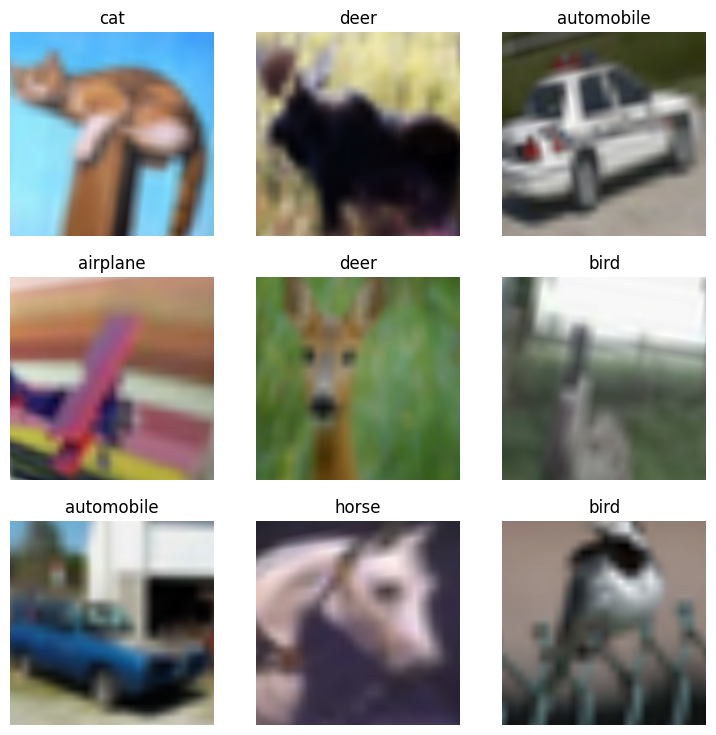

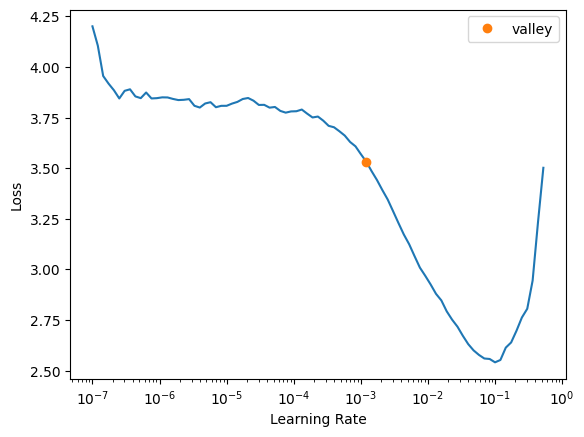

In [20]:
dls.show_batch()

# Create learner
learn = vision_learner(dls, resnet34, metrics=[error_rate, accuracy])

# Find learning rate
learn.lr_find()

# Fine-tune
learn.fine_tune(5, freeze_epochs=1)
learn.recorder.plot_loss()

# Unfreeze and train with discriminative learning rates
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-6, 1e-4))
learn.recorder.plot_metrics()


# Test Time Augmentation
preds, targs = learn.tta()
print(f"Final accuracy: {accuracy(preds, targs).item():.4f}")

# Save the model
learn.save('final_model')

In [21]:
# Function to set up the evaluation directory with reserved samples
def setup_reserved_eval_dir(reserved_files, eval_dir):
    eval_dir.mkdir(parents=True, exist_ok=True)
    for file in reserved_files:
        class_dir = file.parent.name
        dest_dir = eval_dir/class_dir
        dest_dir.mkdir(parents=True, exist_ok=True)
        shutil.copy(file, dest_dir/file.name)

# Create the evaluation directory
path = Path('temp_cifar')
eval_dir = Path('temp_cifar_eval')
setup_reserved_eval_dir(reserved_files, eval_dir)

# Assuming eval_dir is already set up with reserved samples
eval_dir = Path('temp_cifar_eval')

#custom splitter to NOT split data
def nosplit(o):
    return L(int(i) for i in range(len(o))), L()

# Define the DataBlock for evaluation
cifar_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),   # Define the types of input and output
    get_items=get_image_files,            # Function to get image files
    get_y=parent_label,                   # Function to get labels from parent folder names
    item_tfms=Resize(224),
    batch_tfms=[*aug_transforms(size=224, min_scale=0.75),
       Normalize.from_stats(*imagenet_stats)],
    splitter=nosplit
)

# Create DataLoader for evaluation set
eval_dls = cifar_block.dataloaders(eval_dir, bs=64, shuffle_train=False, drop_last=False)

len(eval_dls.train_ds), len(eval_dls.valid_ds) #test set in this case remains inside dls.train
#(10000, 0)

(10000, 0)

In [22]:
# Evaluate on all samples
eval_preds, eval_targs = learn.get_preds(dl=eval_dls.train)
eval_accuracy = accuracy(eval_preds, eval_targs).item()
print(f"Evaluation accuracy on all evaluation samples: {eval_accuracy:.4f}")

Evaluation accuracy on all evaluation samples: 0.9621


In [51]:
# Using test time augmentation
preds, targs = learn.tta(dl=eval_dls.train)

# Calculate accuracy
accuracy_score = accuracy(preds, targs).item()
print(f"Evaluation accuracy with TTA: {accuracy_score:.4f}")

Evaluation accuracy with TTA: 0.9706


### View sample predictions

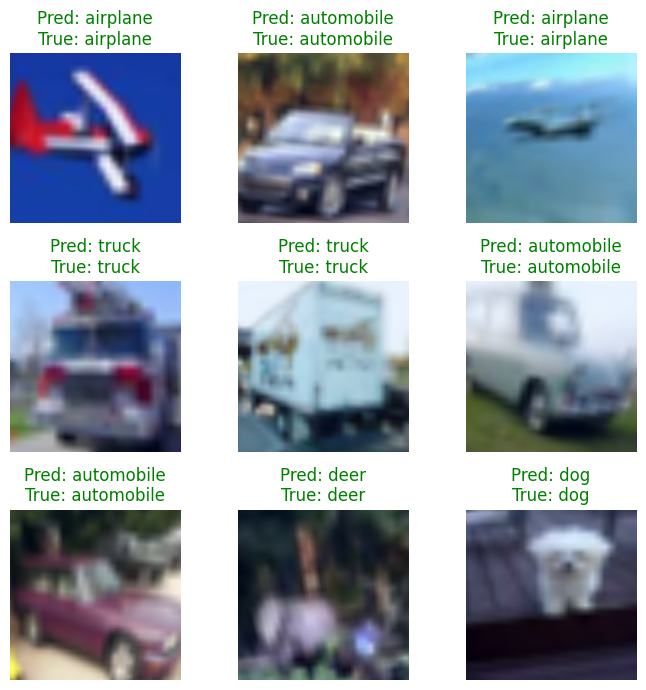

In [ ]:
def plot_sample_predictions(learn, dl, preds, targs, num_samples=9):
    # Get all images and labels
    all_images, all_labels = [], []
    for batch in dl:
        images, labels = batch
        all_images.append(images)
        all_labels.append(labels)
    all_images = torch.cat(all_images)
    all_labels = torch.cat(all_labels)

    # Get predictions
    pred_classes = preds.argmax(dim=1)

    # Get unique classes
    unique_classes = torch.unique(all_labels)
    
    # Create a grid of subplots
    fig, axs = plt.subplots(3, 3, figsize=(7, 7))
    axs = axs.ravel()
    
    # Ensure we have at least one sample from each class
    samples_per_class = num_samples // len(unique_classes)
    extra_samples = num_samples % len(unique_classes)
    
    selected_indices = []
    for cls in unique_classes:
        class_indices = torch.where(all_labels == cls)[0]
        selected_indices.extend(random.sample(class_indices.tolist(), samples_per_class))
    
    # Add any extra samples randomly
    all_indices = list(range(len(all_labels)))
    selected_indices.extend(random.sample([i for i in all_indices if i not in selected_indices], extra_samples))
    
    # Shuffle the selected indices
    random.shuffle(selected_indices)
    
    for i, idx in enumerate(selected_indices[:num_samples]):
        # Get the image and convert to numpy array
        img = all_images[idx].permute(1, 2, 0).cpu().numpy()
        
        # Normalize the image for display
        img = (img - img.min()) / (img.max() - img.min())
        
        # Get the predicted and true labels
        pred_label = learn.dls.vocab[pred_classes[idx]]
        true_label = learn.dls.vocab[all_labels[idx]]
        
        # Set the color based on correctness
        color = 'green' if pred_label == true_label else 'red'
        
        # Plot the image
        axs[i].imshow(img)
        axs[i].axis('off')
        axs[i].set_title(f'Pred: {pred_label}\nTrue: {true_label}', color=color)
    
    plt.tight_layout()
    plt.show()


# Plot sample predictions
plot_sample_predictions(learn, eval_dls.train, preds, targs)